In [53]:
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(PROJECT_ROOT)
import cv2
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import matplotlib.pyplot as plt

In [54]:
NOSE = 2
MOUTH = [10, 11, 12]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from app.modelsAI.unet.segmentaion import load_unet_model,segment_face
from app.modelsAI.unet.unet import preprocess_unet
model = load_unet_model()


In [55]:
def calc_ratio(mask):
    h, w = mask.shape
    total = h * w
    nose_pixels = np.sum(mask == NOSE)
    mouth_pixels = np.sum(np.isin(mask, MOUTH))
    return nose_pixels / total, mouth_pixels / total

In [56]:
VAL_IMG_DIR = os.path.join(PROJECT_ROOT, "dataset", "val_img")
VAL_LABEL_DIR = os.path.join(PROJECT_ROOT, "dataset", "val_label")

===== FINAL THRESHOLDS =====
NOSE_THRESHOLD  = 0.010236
MOUTH_THRESHOLD = 0.004886


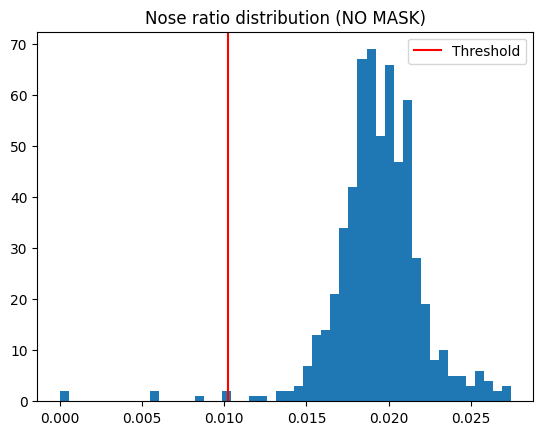

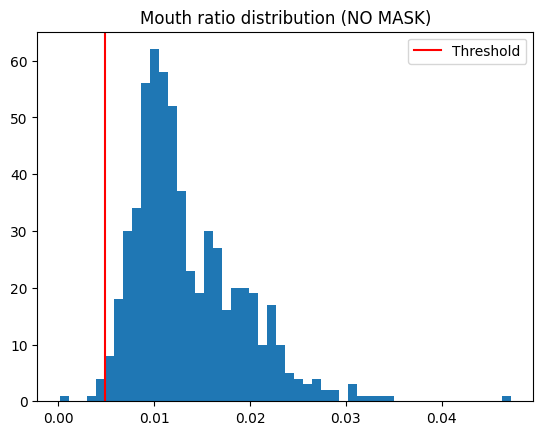

In [58]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

NOSE = 2
MOUTH = [10, 11, 12]

nose_vals = []
mouth_vals = []

for name in os.listdir(VAL_IMG_DIR):
    if not name.lower().endswith((".jpg", ".png")):
        continue

    img_path = os.path.join(VAL_IMG_DIR, name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    img_tensor = preprocess_unet(img)

    with torch.no_grad():
        pred = model(img_tensor)
        pred_mask = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()

    nose_ratio, mouth_ratio = calc_ratio(pred_mask)

    nose_vals.append(nose_ratio)
    mouth_vals.append(mouth_ratio)

nose_vals = np.array(nose_vals)
mouth_vals = np.array(mouth_vals)

# ===== Threshold (lower tail) =====
NOSE_THRESHOLD  = np.percentile(nose_vals, 1)
MOUTH_THRESHOLD = np.percentile(mouth_vals, 1)

print("===== FINAL THRESHOLDS =====")
print(f"NOSE_THRESHOLD  = {NOSE_THRESHOLD:.6f}")
print(f"MOUTH_THRESHOLD = {MOUTH_THRESHOLD:.6f}")

# ===== Visualization =====
plt.hist(nose_vals, bins=50)
plt.axvline(NOSE_THRESHOLD, color="red", label="Threshold")
plt.title("Nose ratio distribution (NO MASK)")
plt.legend()
plt.show()

plt.hist(mouth_vals, bins=50)
plt.axvline(MOUTH_THRESHOLD, color="red", label="Threshold")
plt.title("Mouth ratio distribution (NO MASK)")
plt.legend()
plt.show()